In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None
param_index = 0

In [6]:
# Parameters
dataset = "contraceptive"
dataset_name = "contraceptive"
single_model = "tvae"
gp = False
gp_multiply = False
random_seed = 2
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/contraceptive/tvae/2"
param_index = 2


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/contraceptive/tvae/2


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x7cef66d463b0>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-02-29 22:24:01.603445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 22:24:01.603521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 22:24:01.605533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

In [15]:
preprocessor.adapter_sizes

{'tvae': 46,
 'realtabformer': (24, 72, Embedding(72, 672), True),
 'lct_gan': 40,
 'tab_ddpm_concat': 10}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_3_factory

datasetsn = load_dataset_3_factory(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    cache_dir=path_prefix,
)


In [17]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset

test_set = load_dataset(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/", "datasets_5", dataset_name),
    preprocessor=preprocessor,
    cache_dir=os.path.join(path_prefix, dataset_name, "_cache_test"),
    start=200,
    #stop=600,
    val=False,
    ratio=0,
    drop_first_column=True,
    model=single_model,
)

Caching in ../../../../contraceptive/_cache_test/tvae/all inf False


In [18]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
params = {
    **getattr(PARAMS, dataset_name).BESTS[param_index],
}
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'Body': 'twin_encoder',
 'loss_balancer_meta': True,
 'loss_balancer_log': False,
 'loss_balancer_lbtw': False,
 'pma_skip_small': False,
 'isab_skip_small': False,
 'layer_norm': False,
 'pma_layer_norm': False,
 'attn_residual': True,
 'tf_n_layers_dec': False,
 'tf_isab_rank': 0,
 'tf_layer_norm': False,
 'tf_pma_start': -1,
 'head_n_seeds': 0,
 'tf_pma_low': 8,
 'dropout': 0,
 'combine_mode': 'diff_left',
 'tf_isab_mode': 'separate',
 'grad_loss_fn': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'single_model': True,
 'bias': True,
 'bias_final': True,
 'pma_ffn_mode': 'shared',
 'patience': 10,
 'inds_init_mode': 'fixnorm',
 'grad_clip': 0.775,
 'gradient_penalty_mode': {'gradient_penalty': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'synth_data': 2,
 'dataset_size': 2048,


In [19]:
train_set, val_set = datasetsn(model=params["fixed_role_model"], synth_data=params["synth_data"])

load_dataset_3_factory 2
Caching in ../../../../contraceptive/_cache/tvae/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_2/contraceptive [80, 20]
Caching in ../../../../contraceptive/_cache4/tvae/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_4/contraceptive [80, 20]
Caching in ../../../../contraceptive/_cache5/tvae/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_5/contraceptive [160, 40]
[320, 80]
[320, 80]


In [20]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>


[*] Embedding False True
['tvae'] 1


In [21]:
study_name=f"{model_name}_{dataset_name}"

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

10270216

In [23]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = train_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 1179, 46]             --
├─Adapter: 1-1                                                         [2, 1179, 46]             --
│    └─Sequential: 2-1                                                 [2, 1179, 256]            --
│    │    └─FeedForward: 3-1                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-1                                           [2, 1179, 1024]           48,128
│    │    │    └─Softsign: 4-2                                         [2, 1179, 1024]           --
│    │    └─FeedForward: 3-2                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-3                                           [2, 1179, 1024]           1,049,600
│    │    │    └─Softsign: 4-4                                         [2, 1179, 102

In [24]:
import torch
from ml_utility_loss.loss_learning.estimator.pipeline import train, train_2
from ml_utility_loss.loss_learning.estimator.process_simple import train_epoch, eval as _eval
from ml_utility_loss.params import GradientPenaltyMode
from ml_utility_loss.util import clear_memory
import time
#torch.autograd.set_detect_anomaly(True)

clear_memory()

opt = params["Optim"](model.parameters())
loss = train_2(
    [train_set, val_set, test_set],
    preprocessor=preprocessor,
    whole_model=model,
    optim=opt,
    log_dir="logs",
    checkpoint_dir="checkpoints",
    verbose=True,
    allow_same_prediction=False,
    wandb=wandb,
    study_name=study_name,
    **params
)

wandb: Tracking run with wandb version 0.16.3


wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


g_loss_mul 0.1
Epoch 0


Train loss {'avg_role_model_loss': 0.02241888580356317, 'avg_role_model_std_loss': 1.4905488636076916, 'avg_role_model_mean_pred_loss': 0.0030782962097319457, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.02241888580356317, 'n_size': 320, 'n_batch': 160, 'duration': 142.862961769104, 'duration_batch': 0.8928935110569001, 'duration_size': 0.44644675552845003, 'avg_pred_std': 0.0961261961127093}


Val loss {'avg_role_model_loss': 0.007483271204910125, 'avg_role_model_std_loss': 7.415935450342414, 'avg_role_model_mean_pred_loss': 9.700103195409149e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007483271204910125, 'n_size': 80, 'n_batch': 40, 'duration': 32.79719305038452, 'duration_batch': 0.8199298262596131, 'duration_size': 0.40996491312980654, 'avg_pred_std': 0.030276008496821306}
Epoch 1


Train loss {'avg_role_model_loss': 0.004170822119840522, 'avg_role_model_std_loss': 2.427984166694133, 'avg_role_model_mean_pred_loss': 5.6218089488430103e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.004170822119840522, 'n_size': 320, 'n_batch': 160, 'duration': 140.515380859375, 'duration_batch': 0.8782211303710937, 'duration_size': 0.43911056518554686, 'avg_pred_std': 0.06761386157022571}


Val loss {'avg_role_model_loss': 0.0027781161175880697, 'avg_role_model_std_loss': 5.97971810359972, 'avg_role_model_mean_pred_loss': 8.342038965802879e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0027781161175880697, 'n_size': 80, 'n_batch': 40, 'duration': 32.894118309020996, 'duration_batch': 0.8223529577255249, 'duration_size': 0.41117647886276243, 'avg_pred_std': 0.024398993137219806}
Epoch 2


Train loss {'avg_role_model_loss': 0.0032142372105653295, 'avg_role_model_std_loss': 3.1775326946756253, 'avg_role_model_mean_pred_loss': 9.600223262965901e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0032142372105653295, 'n_size': 320, 'n_batch': 160, 'duration': 144.2568175792694, 'duration_batch': 0.9016051098704339, 'duration_size': 0.4508025549352169, 'avg_pred_std': 0.06473975269825587}


Val loss {'avg_role_model_loss': 0.002925431027142622, 'avg_role_model_std_loss': 6.108939102519116, 'avg_role_model_mean_pred_loss': 8.98504544019768e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002925431027142622, 'n_size': 80, 'n_batch': 40, 'duration': 35.61764717102051, 'duration_batch': 0.8904411792755127, 'duration_size': 0.44522058963775635, 'avg_pred_std': 0.028732989538184484}
Epoch 3


Train loss {'avg_role_model_loss': 0.003577234379551553, 'avg_role_model_std_loss': 2.9195899648459376, 'avg_role_model_mean_pred_loss': 4.348199776086897e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003577234379551553, 'n_size': 320, 'n_batch': 160, 'duration': 150.63309359550476, 'duration_batch': 0.9414568349719048, 'duration_size': 0.4707284174859524, 'avg_pred_std': 0.06363038770923594}


Val loss {'avg_role_model_loss': 0.0032030581480285035, 'avg_role_model_std_loss': 5.47701075857707, 'avg_role_model_mean_pred_loss': 1.4309088606778708e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0032030581480285035, 'n_size': 80, 'n_batch': 40, 'duration': 32.49244570732117, 'duration_batch': 0.8123111426830292, 'duration_size': 0.4061555713415146, 'avg_pred_std': 0.021739204511686695}
Epoch 4


Train loss {'avg_role_model_loss': 0.002611448067193578, 'avg_role_model_std_loss': 1.8328958396290929, 'avg_role_model_mean_pred_loss': 8.810737564255572e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002611448067193578, 'n_size': 320, 'n_batch': 160, 'duration': 143.45851230621338, 'duration_batch': 0.8966157019138337, 'duration_size': 0.44830785095691683, 'avg_pred_std': 0.07633217830557441}


Val loss {'avg_role_model_loss': 0.0030096135813437288, 'avg_role_model_std_loss': 5.497269465320635, 'avg_role_model_mean_pred_loss': 8.17212617150176e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0030096135813437288, 'n_size': 80, 'n_batch': 40, 'duration': 34.19865131378174, 'duration_batch': 0.8549662828445435, 'duration_size': 0.42748314142227173, 'avg_pred_std': 0.01728544359702937}
Epoch 5


Train loss {'avg_role_model_loss': 0.002066187719401569, 'avg_role_model_std_loss': 1.418562725057735, 'avg_role_model_mean_pred_loss': 4.818185051591941e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002066187719401569, 'n_size': 320, 'n_batch': 160, 'duration': 141.1322615146637, 'duration_batch': 0.8820766344666481, 'duration_size': 0.44103831723332404, 'avg_pred_std': 0.07070515162549781}


Val loss {'avg_role_model_loss': 0.002357064618456661, 'avg_role_model_std_loss': 3.038762490750969, 'avg_role_model_mean_pred_loss': 4.724545272427605e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002357064618456661, 'n_size': 80, 'n_batch': 40, 'duration': 32.73992657661438, 'duration_batch': 0.8184981644153595, 'duration_size': 0.40924908220767975, 'avg_pred_std': 0.019966062564344612}
Epoch 6


Train loss {'avg_role_model_loss': 0.0018150892569863686, 'avg_role_model_std_loss': 1.9370867185192977, 'avg_role_model_mean_pred_loss': 4.895915542963466e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0018150892569863686, 'n_size': 320, 'n_batch': 160, 'duration': 142.5343050956726, 'duration_batch': 0.8908394068479538, 'duration_size': 0.4454197034239769, 'avg_pred_std': 0.06771241171363726}


Val loss {'avg_role_model_loss': 0.002098434802974225, 'avg_role_model_std_loss': 2.5296149099483842, 'avg_role_model_mean_pred_loss': 6.119135131865683e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002098434802974225, 'n_size': 80, 'n_batch': 40, 'duration': 33.130537033081055, 'duration_batch': 0.8282634258270264, 'duration_size': 0.4141317129135132, 'avg_pred_std': 0.036213114765996576}
Epoch 7


Train loss {'avg_role_model_loss': 0.0017754018189464205, 'avg_role_model_std_loss': 1.0608564720709155, 'avg_role_model_mean_pred_loss': 4.110462002784865e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0017754018189464205, 'n_size': 320, 'n_batch': 160, 'duration': 150.93800163269043, 'duration_batch': 0.9433625102043152, 'duration_size': 0.4716812551021576, 'avg_pred_std': 0.07812782935689029}


Val loss {'avg_role_model_loss': 0.002651070246429299, 'avg_role_model_std_loss': 5.481469099184153, 'avg_role_model_mean_pred_loss': 8.274616622792885e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002651070246429299, 'n_size': 80, 'n_batch': 40, 'duration': 36.68884253501892, 'duration_batch': 0.917221063375473, 'duration_size': 0.4586105316877365, 'avg_pred_std': 0.0201021930330171}
Epoch 8


Train loss {'avg_role_model_loss': 0.0016320147636861293, 'avg_role_model_std_loss': 1.572569604070008, 'avg_role_model_mean_pred_loss': 3.280935549836465e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0016320147636861293, 'n_size': 320, 'n_batch': 160, 'duration': 152.10332083702087, 'duration_batch': 0.9506457552313805, 'duration_size': 0.47532287761569025, 'avg_pred_std': 0.07706006977591642}


Val loss {'avg_role_model_loss': 0.0021084082123252303, 'avg_role_model_std_loss': 4.821968620683037, 'avg_role_model_mean_pred_loss': 7.140439676618648e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0021084082123252303, 'n_size': 80, 'n_batch': 40, 'duration': 35.41457486152649, 'duration_batch': 0.8853643715381623, 'duration_size': 0.44268218576908114, 'avg_pred_std': 0.032409553838078864}
Epoch 9


Train loss {'avg_role_model_loss': 0.0014390503529739362, 'avg_role_model_std_loss': 1.1130779689192227, 'avg_role_model_mean_pred_loss': 1.9856122689985296e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0014390503529739362, 'n_size': 320, 'n_batch': 160, 'duration': 148.04402089118958, 'duration_batch': 0.9252751305699348, 'duration_size': 0.4626375652849674, 'avg_pred_std': 0.07865846673303167}


Val loss {'avg_role_model_loss': 0.002113264991157848, 'avg_role_model_std_loss': 2.781704166371675, 'avg_role_model_mean_pred_loss': 4.972169583404757e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002113264991157848, 'n_size': 80, 'n_batch': 40, 'duration': 33.858819007873535, 'duration_batch': 0.8464704751968384, 'duration_size': 0.4232352375984192, 'avg_pred_std': 0.02809684935346013}
Epoch 10


Train loss {'avg_role_model_loss': 0.001374225791067829, 'avg_role_model_std_loss': 1.163778030275184, 'avg_role_model_mean_pred_loss': 1.7583196497888975e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.001374225791067829, 'n_size': 320, 'n_batch': 160, 'duration': 145.61796760559082, 'duration_batch': 0.9101122975349426, 'duration_size': 0.4550561487674713, 'avg_pred_std': 0.072609595393169}


Val loss {'avg_role_model_loss': 0.0023332797987222877, 'avg_role_model_std_loss': 2.608034198338737, 'avg_role_model_mean_pred_loss': 1.0012352827615257e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0023332797987222877, 'n_size': 80, 'n_batch': 40, 'duration': 33.24501919746399, 'duration_batch': 0.8311254799365997, 'duration_size': 0.41556273996829984, 'avg_pred_std': 0.03622158533107722}
Epoch 11


Train loss {'avg_role_model_loss': 0.0013136249404567478, 'avg_role_model_std_loss': 1.105370874132261, 'avg_role_model_mean_pred_loss': 2.0836581030414523e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013136249404567478, 'n_size': 320, 'n_batch': 160, 'duration': 144.06322360038757, 'duration_batch': 0.9003951475024223, 'duration_size': 0.45019757375121117, 'avg_pred_std': 0.07791482849102067}


Val loss {'avg_role_model_loss': 0.0020939761153385915, 'avg_role_model_std_loss': 7.381703513306002, 'avg_role_model_mean_pred_loss': 3.89069975454473e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0020939761153385915, 'n_size': 80, 'n_batch': 40, 'duration': 33.347615242004395, 'duration_batch': 0.8336903810501098, 'duration_size': 0.4168451905250549, 'avg_pred_std': 0.01896329457867978}
Epoch 12


Train loss {'avg_role_model_loss': 0.0013007374736943688, 'avg_role_model_std_loss': 0.8016777972321465, 'avg_role_model_mean_pred_loss': 1.6661171600203944e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013007374736943688, 'n_size': 320, 'n_batch': 160, 'duration': 143.7109453678131, 'duration_batch': 0.8981934085488319, 'duration_size': 0.44909670427441595, 'avg_pred_std': 0.07403813572964282}


Val loss {'avg_role_model_loss': 0.0021091806715048734, 'avg_role_model_std_loss': 2.195618169948898, 'avg_role_model_mean_pred_loss': 6.716770201746968e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0021091806715048734, 'n_size': 80, 'n_batch': 40, 'duration': 33.3885440826416, 'duration_batch': 0.8347136020660401, 'duration_size': 0.41735680103302003, 'avg_pred_std': 0.03174531738768564}
Epoch 13


Train loss {'avg_role_model_loss': 0.0011258274745216568, 'avg_role_model_std_loss': 0.9933245053406304, 'avg_role_model_mean_pred_loss': 1.2559000061217402e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0011258274745216568, 'n_size': 320, 'n_batch': 160, 'duration': 143.82260847091675, 'duration_batch': 0.8988913029432297, 'duration_size': 0.44944565147161486, 'avg_pred_std': 0.07367398725546082}


Val loss {'avg_role_model_loss': 0.002973305231353152, 'avg_role_model_std_loss': 2.332661612354639, 'avg_role_model_mean_pred_loss': 1.9470425126388857e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002973305231353152, 'n_size': 80, 'n_batch': 40, 'duration': 33.963603019714355, 'duration_batch': 0.8490900754928589, 'duration_size': 0.42454503774642943, 'avg_pred_std': 0.035911593766650186}
Epoch 14


Train loss {'avg_role_model_loss': 0.0010081856245165, 'avg_role_model_std_loss': 1.8124559902420032, 'avg_role_model_mean_pred_loss': 1.1379342504010126e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0010081856245165, 'n_size': 320, 'n_batch': 160, 'duration': 144.61974716186523, 'duration_batch': 0.9038734197616577, 'duration_size': 0.45193670988082885, 'avg_pred_std': 0.07099440268893886}


Val loss {'avg_role_model_loss': 0.002199153335527626, 'avg_role_model_std_loss': 2.3161073656544886, 'avg_role_model_mean_pred_loss': 7.577638564465472e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002199153335527626, 'n_size': 80, 'n_batch': 40, 'duration': 33.57773303985596, 'duration_batch': 0.8394433259963989, 'duration_size': 0.41972166299819946, 'avg_pred_std': 0.02861409220568021}
Epoch 15


Train loss {'avg_role_model_loss': 0.0010586415690795547, 'avg_role_model_std_loss': 1.0111776571605908, 'avg_role_model_mean_pred_loss': 1.3155730025755604e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0010586415690795547, 'n_size': 320, 'n_batch': 160, 'duration': 143.99448657035828, 'duration_batch': 0.8999655410647392, 'duration_size': 0.4499827705323696, 'avg_pred_std': 0.07437738951684877}


Val loss {'avg_role_model_loss': 0.0024275374956232556, 'avg_role_model_std_loss': 2.65694752669535, 'avg_role_model_mean_pred_loss': 1.2085388890881177e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0024275374956232556, 'n_size': 80, 'n_batch': 40, 'duration': 33.66980719566345, 'duration_batch': 0.8417451798915863, 'duration_size': 0.42087258994579313, 'avg_pred_std': 0.034823847954976374}
Epoch 16


Train loss {'avg_role_model_loss': 0.0008538674877796026, 'avg_role_model_std_loss': 1.5765032050085541, 'avg_role_model_mean_pred_loss': 5.374222879224455e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0008538674877796026, 'n_size': 320, 'n_batch': 160, 'duration': 143.34916639328003, 'duration_batch': 0.8959322899580002, 'duration_size': 0.4479661449790001, 'avg_pred_std': 0.08046830528701321}


Val loss {'avg_role_model_loss': 0.0022838078687641428, 'avg_role_model_std_loss': 2.0230109165978774, 'avg_role_model_mean_pred_loss': 9.47888851559331e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022838078687641428, 'n_size': 80, 'n_batch': 40, 'duration': 33.02995800971985, 'duration_batch': 0.8257489502429962, 'duration_size': 0.4128744751214981, 'avg_pred_std': 0.030621698120376094}
Epoch 17


Train loss {'avg_role_model_loss': 0.0008248503026644372, 'avg_role_model_std_loss': 0.35676954403032646, 'avg_role_model_mean_pred_loss': 7.142933498651121e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0008248503026644372, 'n_size': 320, 'n_batch': 160, 'duration': 143.77559542655945, 'duration_batch': 0.8985974714159966, 'duration_size': 0.4492987357079983, 'avg_pred_std': 0.08080137882643612}


Val loss {'avg_role_model_loss': 0.0023548384517198427, 'avg_role_model_std_loss': 4.805163549015765, 'avg_role_model_mean_pred_loss': 1.1883367263940125e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0023548384517198427, 'n_size': 80, 'n_batch': 40, 'duration': 33.76482057571411, 'duration_batch': 0.8441205143928527, 'duration_size': 0.42206025719642637, 'avg_pred_std': 0.03005029430896684}
Epoch 18


Train loss {'avg_role_model_loss': 0.0007936206464748352, 'avg_role_model_std_loss': 1.0760348675862972, 'avg_role_model_mean_pred_loss': 7.879423535514518e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0007936206464748352, 'n_size': 320, 'n_batch': 160, 'duration': 144.43712854385376, 'duration_batch': 0.902732053399086, 'duration_size': 0.451366026699543, 'avg_pred_std': 0.0707601236276787}


Val loss {'avg_role_model_loss': 0.0022624223027378322, 'avg_role_model_std_loss': 4.505487352633622, 'avg_role_model_mean_pred_loss': 1.0153568444593031e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022624223027378322, 'n_size': 80, 'n_batch': 40, 'duration': 33.66985249519348, 'duration_batch': 0.841746312379837, 'duration_size': 0.4208731561899185, 'avg_pred_std': 0.03378975939194788}
Epoch 19


Train loss {'avg_role_model_loss': 0.0007593693141508595, 'avg_role_model_std_loss': 0.6788086620792548, 'avg_role_model_mean_pred_loss': 5.805468950893806e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0007593693141508595, 'n_size': 320, 'n_batch': 160, 'duration': 144.87138056755066, 'duration_batch': 0.9054461285471916, 'duration_size': 0.4527230642735958, 'avg_pred_std': 0.08014883432224451}


wandb:                                                                                


Val loss {'avg_role_model_loss': 0.002318795861719991, 'avg_role_model_std_loss': 2.6745841488044872, 'avg_role_model_mean_pred_loss': 1.0226613121978867e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002318795861719991, 'n_size': 80, 'n_batch': 40, 'duration': 33.691651344299316, 'duration_batch': 0.842291283607483, 'duration_size': 0.4211456418037415, 'avg_pred_std': 0.03418012205511332}
Time out: 3627.9625329971313/3600


wandb: 
wandb: Run history:
wandb:                       avg_loss_test █▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁
wandb:                      avg_loss_train █▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_embed_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_embed_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_mag_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                   avg_pred_std_test ▆▄▅▃▁▂█▂▇▅█▂▆█▅▇▆▆▇
wandb:                  avg_pred_std_train █▂▁▁▄▃▂▄▄▄▃▄▃▃▃▃▅▅▃
wandb:      avg_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      avg_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_model_g_mag_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            avg_role_model_loss_test █▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁
wandb:           avg_role_m

wandb: You can sync this run to the cloud by running:
wandb: wandb sync /kaggle/working/eval/contraceptive/tvae/2/wandb/offline-run-20240229_222415-ekgllb0j


wandb: Find logs at: ./wandb/offline-run-20240229_222415-ekgllb0j/logs


/opt/conda/lib/python3.10/site-packages/ml_utility_loss/loss_learning/estimator/process.py:348: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at ../aten/src/ATen/native/Correlation.cpp:100.)
  corr_mat = torch.corrcoef(stack)


Eval loss {'role_model': 'tvae', 'n_size': 399, 'n_batch': 200, 'role_model_metrics': {'avg_loss': 0.0012284579364314312, 'avg_g_mag_loss': nan, 'avg_g_cos_loss': 0.010551982342433416, 'pred_duration': 3.313055992126465, 'grad_duration': 2.6909384727478027, 'total_duration': 6.003994464874268, 'pred_std': 0.057808153331279755, 'std_loss': 0.01108523365110159, 'mean_pred_loss': 9.105955314225866e-07, 'pred_rmse': 0.03504936397075653, 'pred_mae': 0.02793470025062561, 'pred_mape': 0.06429529935121536, 'grad_rmse': 0.040074676275253296, 'grad_mae': 0.03164428845047951, 'grad_mape': 0.6164292097091675}, 'non_role_model_metrics': {'avg_loss': 0, 'avg_g_mag_loss': 0, 'avg_g_cos_loss': 0, 'avg_pred_duration': 0, 'avg_grad_duration': 0, 'avg_total_duration': 0, 'avg_pred_std': 0, 'avg_std_loss': 0, 'avg_mean_pred_loss': 0}, 'avg_metrics': {'avg_loss': 0.0012284579364314312, 'avg_g_mag_loss': nan, 'avg_g_cos_loss': 0.010551982342433416, 'avg_pred_duration': 3.313055992126465, 'avg_grad_duration'

In [25]:
model = loss["whole_model"]
opt = loss["optim"]

In [26]:
import torch
from copy import deepcopy

torch.save(deepcopy(model.state_dict()), "model.pt")
torch.save(deepcopy(opt.state_dict()), "optim.pt")

<Axes: >

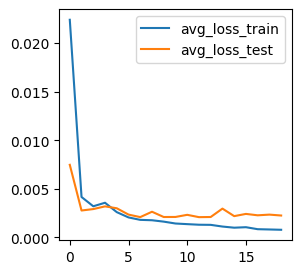

In [27]:
history = loss["history"]
history.to_csv("history.csv")
history[["avg_loss_train", "avg_loss_test"]].plot()

In [28]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

/opt/conda/lib/python3.10/site-packages/ml_utility_loss/loss_learning/estimator/process.py:348: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at ../aten/src/ATen/native/Correlation.cpp:100.)
  corr_mat = torch.corrcoef(stack)


In [29]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  grad_mae  \
tvae        0.014026             NaN  0.001228       2.706435  0.031644   

      grad_mape  grad_rmse  mean_pred_loss  pred_duration  pred_mae  \
tvae   0.616429   0.040075    9.105956e-07       3.237632  0.027935   

      pred_mape  pred_rmse  pred_std  std_loss  total_duration  
tvae   0.064295   0.035049  0.057808  0.011085        5.944067

In [30]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [31]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../contraceptive/_cache_test/tvae/all inf False


/opt/conda/lib/python3.10/site-packages/ml_utility_loss/loss_learning/estimator/process.py:348: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at ../aten/src/ATen/native/Correlation.cpp:100.)
  corr_mat = torch.corrcoef(stack)


In [32]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [33]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'tvae': 0.42948681272958456}


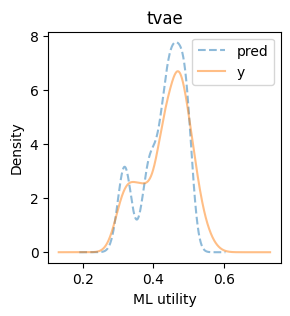

In [34]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

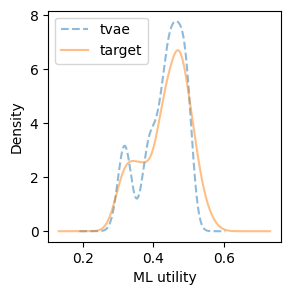

In [35]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

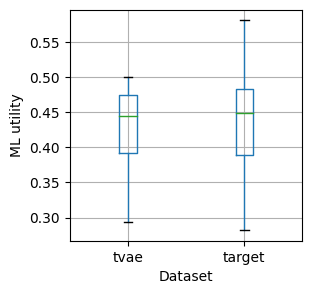

In [36]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

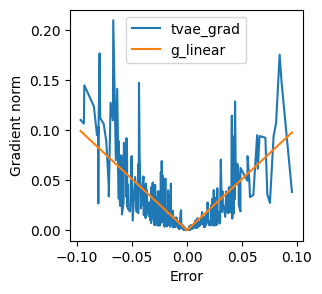

In [37]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""